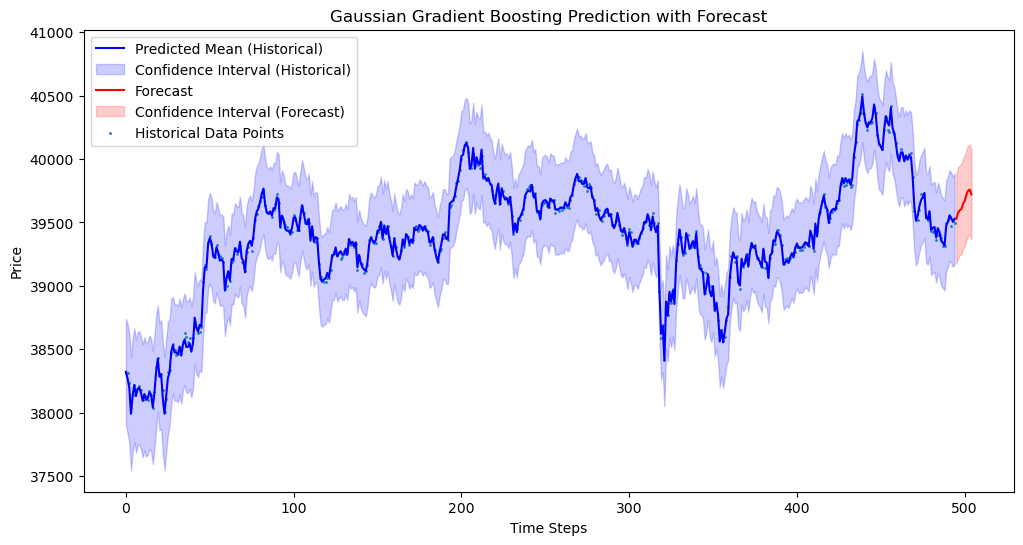

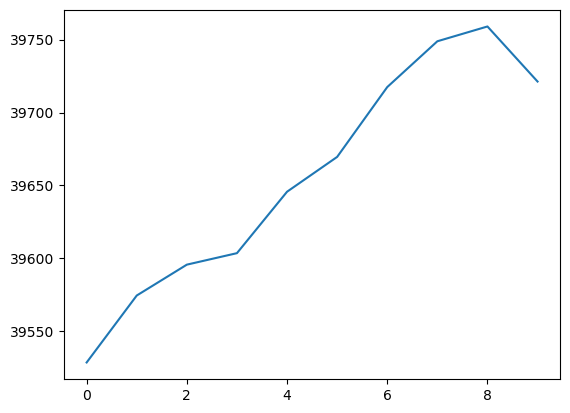

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import torch
from torch.distributions.normal import Normal
from torch.autograd import Variable
from typing import List, Optional, Tuple

class GaussianGradientBoosting:
    # [Previous class implementation remains the same]
    def __init__(self,
                 learning_rate: float = 0.01,
                 max_depth: int = 1,
                 n_estimators: int = 100):

        self.learning_rate: float = learning_rate
        self.max_depth: int = max_depth
        self.n_estimators: int = n_estimators

        self.init_mu: Optional[float] = None
        self.mu_trees: List[DecisionTreeRegressor] = []
        
        self.init_sigma: Optional[float] = None
        self.sigma_trees: List[DecisionTreeRegressor] = []
        
        self.is_trained: bool = False

    def predict(self, X: np.array) -> np.array:
        assert self.is_trained

        mus = self._predict_mus(X).reshape(-1, 1)
        log_sigmas = np.exp(self._predict_log_sigmas(X).reshape(-1, 1))

        return np.concatenate([mus, log_sigmas], 1) 

    def _predict_raw(self, X: np.array) -> np.array:
        assert self.is_trained

        mus = self._predict_mus(X).reshape(-1, 1)
        log_sigmas = self._predict_log_sigmas(X).reshape(-1, 1)

        return np.concatenate([mus, log_sigmas], 1) 

    def fit(self, X: np.array, y: np.array) -> None:
        self._fit_initial(y)

        self.is_trained = True

        for _ in range(self.n_estimators):
            y_pred = self._predict_raw(X)

            gradients = self._get_gradients(y, y_pred)

            mu_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            mu_tree.fit(X, gradients[:, 0])
            self.mu_trees.append(mu_tree)

            sigma_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            sigma_tree.fit(X, gradients[:, 1])
            self.sigma_trees.append(sigma_tree)

    def _fit_initial(self, y: np.array) -> None:
        assert not self.is_trained
        
        self.init_mu = np.mean(y)
        self.init_sigma = np.log(np.std(y))

    def _get_gradients(self, y: np.array, y_pred: np.array) -> np.array:
        y_torch = torch.tensor(y).float()
        y_pred_torch = Variable(torch.tensor(y_pred).float(), requires_grad=True)

        sigma = torch.clamp(torch.exp(y_pred_torch[:, 1]), min=1e-6, max=10)
        normal_dist = Normal(y_pred_torch[:, 0], sigma).log_prob(y_torch).sum()

        normal_dist.backward()
        return y_pred_torch.grad.numpy()

    def _predict_mus(self, X: np.array) -> np.array:
        output = np.zeros(len(X))
        output += self.init_mu

        for tree in self.mu_trees:
            output += self.learning_rate * tree.predict(X)

        return output

    def _predict_log_sigmas(self, X: np.array) -> np.array:
        output = np.zeros(len(X))
        output += self.init_sigma

        for tree in self.sigma_trees:
            output += self.learning_rate * tree.predict(X)

        return output

def create_features(data: np.array, lookback: int = 5) -> Tuple[np.array, np.array]:
    """
    Create features from time series data including:
    - Previous values (lookback window)
    - Rolling statistics
    - Price changes
    """
    df = pd.DataFrame(data, columns=['close'])
    
    # Previous values
    for i in range(1, lookback + 1):
        df[f'prev_{i}'] = df['close'].shift(i)
    
    # Rolling statistics
    df['rolling_mean'] = df['close'].rolling(window=lookback).mean()
    df['rolling_std'] = df['close'].rolling(window=lookback).std()
    
    # Price changes
    df['change_1'] = df['close'].pct_change()
    df['change_2'] = df['close'].pct_change(2)
    df['change_5'] = df['close'].pct_change(5)
    
    # Optional: Add more sophisticated features here
    df['momentum'] = df['close'] - df['rolling_mean']
    df['volatility'] = df['rolling_std'] / df['rolling_mean']
    
    # Drop NaN values resulting from calculations
    df.dropna(inplace=True)
    
    # Separate features and target
    y = df['close'].values
    X = df.drop('close', axis=1).values
    
    return X, y

def generate_future_features(X: np.array, y_pred: np.array, lookback: int = 5) -> np.array:
    """
    Generate features for future predictions using the most recent predictions
    """
    future_features = []
    last_values = list(y_pred[-lookback:])
    
    # Generate one new row of features
    row = []
    
    # Previous values
    for i in range(lookback):
        row.append(last_values[-(i+1)])
    
    # Rolling statistics
    row.append(np.mean(last_values))  # rolling_mean
    row.append(np.std(last_values))   # rolling_std
    
    # Price changes
    row.append((last_values[-1] - last_values[-2]) / last_values[-2])  # change_1
    row.append((last_values[-1] - last_values[-3]) / last_values[-3])  # change_2
    row.append((last_values[-1] - last_values[-5]) / last_values[-5])  # change_5
    
    # Momentum and volatility
    row.append(last_values[-1] - np.mean(last_values))  # momentum
    row.append(np.std(last_values) / np.mean(last_values))  # volatility
    
    return np.array(row).reshape(1, -1)

# [Previous GaussianGradientBoosting class implementation remains the same]

# Fetch and prepare data
def fetch_oanda_data(instrument: str, granularity: str, count: int = 500):
    access_token = "e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d"
    client = API(access_token)
    
    params = {
        "granularity": granularity,
        "count": count
    }
    request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = client.request(request)
    
    data = [
        {
            "time": candle["time"],
            "close": float(candle["mid"]["c"])
        }
        for candle in response["candles"]
    ]
    return pd.DataFrame(data)

# Main execution
instrument = "JP225_USD"
granularity = "H1"
df = fetch_oanda_data(instrument, granularity)
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)


# Preprocess data
df.dropna(inplace=True)
y_raw = df["close"].values

# Create features
X_raw, y = create_features(y_raw, lookback=5)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Fit model
model = GaussianGradientBoosting(n_estimators=100)
model.fit(X, y_scaled)

# Generate historical predictions
historical_predictions = model.predict(X)
historical_mean = scaler_y.inverse_transform(historical_predictions[:, 0].reshape(-1, 1)).flatten()
historical_std = scaler_y.inverse_transform((historical_predictions[:, 0] + historical_predictions[:, 1]).reshape(-1, 1)).flatten() - historical_mean

# Generate forecasts
n_forecast_steps = 10
forecast_mean = []
forecast_std = []
current_features = X[-1:]  # Start with the last known features

for _ in range(n_forecast_steps):
    # Predict next value
    pred = model.predict(current_features)
    pred_mean = scaler_y.inverse_transform(pred[:, 0].reshape(-1, 1)).flatten()[0]
    pred_std = (scaler_y.inverse_transform((pred[:, 0] + pred[:, 1]).reshape(-1, 1)).flatten() - pred_mean)[0]
    
    forecast_mean.append(pred_mean)
    forecast_std.append(pred_std)
    
    # Generate features for next prediction
    if len(forecast_mean) < n_forecast_steps:
        future_features = generate_future_features(X_raw, 
                                                np.concatenate([y_raw, forecast_mean]),
                                                lookback=5)
        current_features = scaler_X.transform(future_features)

# Plotting
plt.figure(figsize=(12, 6))

# Plot historical data and predictions
time_index = np.arange(len(historical_mean))
plt.plot(time_index, historical_mean, c='b', label="Predicted Mean (Historical)")
plt.fill_between(time_index,
                 historical_mean - 2 * historical_std,
                 historical_mean + 2 * historical_std,
                 color='b', alpha=0.2, label="Confidence Interval (Historical)")

# Plot forecast - Fixed indexing
forecast_index = np.arange(len(historical_mean), len(historical_mean) + len(forecast_mean))  # Remove the -1
plt.plot(forecast_index, forecast_mean, c='r', label="Forecast")
plt.fill_between(forecast_index,
                 np.array(forecast_mean) - 2 * np.array(forecast_std),
                 np.array(forecast_mean) + 2 * np.array(forecast_std),
                 color='r', alpha=0.2, label="Confidence Interval (Forecast)")

# Plot actual data
plt.scatter(time_index, y, s=1, label="Historical Data Points")

# Plot vertical line at forecast start
#plt.axvline(x=len(historical_mean), color='gray', linestyle='--', label="Forecast Start")
plt.legend()
plt.title("Gaussian Gradient Boosting Prediction with Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

plt.plot(forecast_mean)